Tutorial from: https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [2]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [3]:

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [4]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [5]:

### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [6]:

def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show() 

	 partial train loss (single batch): 0.253685
	 partial train loss (single batch): 0.246147
	 partial train loss (single batch): 0.240374
	 partial train loss (single batch): 0.235263
	 partial train loss (single batch): 0.231743
	 partial train loss (single batch): 0.228198
	 partial train loss (single batch): 0.225119
	 partial train loss (single batch): 0.222001
	 partial train loss (single batch): 0.219414
	 partial train loss (single batch): 0.217530
	 partial train loss (single batch): 0.215160
	 partial train loss (single batch): 0.213147
	 partial train loss (single batch): 0.210774
	 partial train loss (single batch): 0.208605
	 partial train loss (single batch): 0.206974
	 partial train loss (single batch): 0.204702
	 partial train loss (single batch): 0.203072
	 partial train loss (single batch): 0.200950
	 partial train loss (single batch): 0.199008
	 partial train loss (single batch): 0.196645
	 partial train loss (single batch): 0.195075
	 partial train loss (single batch

	 partial train loss (single batch): 0.067152
	 partial train loss (single batch): 0.067594
	 partial train loss (single batch): 0.066220
	 partial train loss (single batch): 0.065867
	 partial train loss (single batch): 0.066656
	 partial train loss (single batch): 0.066054
	 partial train loss (single batch): 0.065630

 EPOCH 1/30 	 train loss 0.12217003107070923 	 val loss 0.0651530846953392


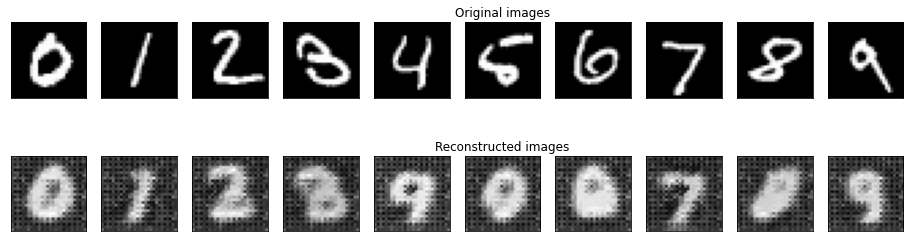

	 partial train loss (single batch): 0.064497
	 partial train loss (single batch): 0.064747
	 partial train loss (single batch): 0.065093
	 partial train loss (single batch): 0.065091
	 partial train loss (single batch): 0.064634
	 partial train loss (single batch): 0.064186
	 partial train loss (single batch): 0.064315
	 partial train loss (single batch): 0.063852
	 partial train loss (single batch): 0.063683
	 partial train loss (single batch): 0.062489
	 partial train loss (single batch): 0.063190
	 partial train loss (single batch): 0.062612
	 partial train loss (single batch): 0.063130
	 partial train loss (single batch): 0.063534
	 partial train loss (single batch): 0.060763
	 partial train loss (single batch): 0.062382
	 partial train loss (single batch): 0.061988
	 partial train loss (single batch): 0.062202
	 partial train loss (single batch): 0.061219
	 partial train loss (single batch): 0.062060
	 partial train loss (single batch): 0.061342
	 partial train loss (single batch

	 partial train loss (single batch): 0.045603
	 partial train loss (single batch): 0.046392
	 partial train loss (single batch): 0.045308
	 partial train loss (single batch): 0.045378
	 partial train loss (single batch): 0.046262
	 partial train loss (single batch): 0.045399
	 partial train loss (single batch): 0.045386

 EPOCH 2/30 	 train loss 0.05299103632569313 	 val loss 0.04565272852778435


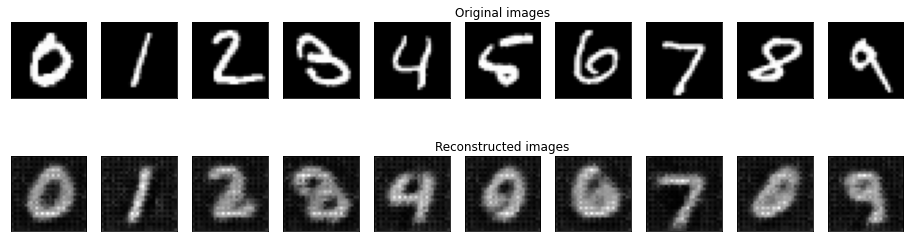

	 partial train loss (single batch): 0.044147
	 partial train loss (single batch): 0.044794
	 partial train loss (single batch): 0.045676
	 partial train loss (single batch): 0.045844
	 partial train loss (single batch): 0.045607
	 partial train loss (single batch): 0.044942
	 partial train loss (single batch): 0.045188
	 partial train loss (single batch): 0.044974
	 partial train loss (single batch): 0.045279
	 partial train loss (single batch): 0.043567
	 partial train loss (single batch): 0.044680
	 partial train loss (single batch): 0.043944
	 partial train loss (single batch): 0.045216
	 partial train loss (single batch): 0.045541
	 partial train loss (single batch): 0.042761
	 partial train loss (single batch): 0.044864
	 partial train loss (single batch): 0.044170
	 partial train loss (single batch): 0.044617
	 partial train loss (single batch): 0.043238
	 partial train loss (single batch): 0.044764
	 partial train loss (single batch): 0.044198
	 partial train loss (single batch

	 partial train loss (single batch): 0.036640
	 partial train loss (single batch): 0.037885
	 partial train loss (single batch): 0.036885
	 partial train loss (single batch): 0.037476
	 partial train loss (single batch): 0.037742
	 partial train loss (single batch): 0.037089
	 partial train loss (single batch): 0.037253

 EPOCH 3/30 	 train loss 0.040559448301792145 	 val loss 0.03706708550453186


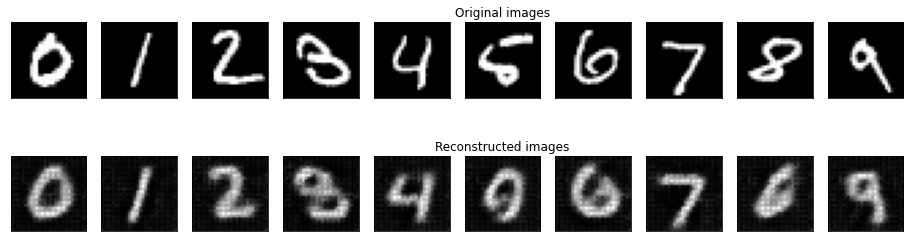

	 partial train loss (single batch): 0.035892
	 partial train loss (single batch): 0.036152
	 partial train loss (single batch): 0.037319
	 partial train loss (single batch): 0.037999
	 partial train loss (single batch): 0.037857
	 partial train loss (single batch): 0.036935
	 partial train loss (single batch): 0.037268
	 partial train loss (single batch): 0.037237
	 partial train loss (single batch): 0.037846
	 partial train loss (single batch): 0.035332
	 partial train loss (single batch): 0.036754
	 partial train loss (single batch): 0.035913
	 partial train loss (single batch): 0.036852
	 partial train loss (single batch): 0.037712
	 partial train loss (single batch): 0.034814
	 partial train loss (single batch): 0.037226
	 partial train loss (single batch): 0.036515
	 partial train loss (single batch): 0.036867
	 partial train loss (single batch): 0.035253
	 partial train loss (single batch): 0.036959
	 partial train loss (single batch): 0.036690
	 partial train loss (single batch

	 partial train loss (single batch): 0.033946
	 partial train loss (single batch): 0.032719
	 partial train loss (single batch): 0.034506
	 partial train loss (single batch): 0.033459
	 partial train loss (single batch): 0.034029
	 partial train loss (single batch): 0.033879
	 partial train loss (single batch): 0.033441
	 partial train loss (single batch): 0.034083

 EPOCH 4/30 	 train loss 0.03490326181054115 	 val loss 0.03365892544388771


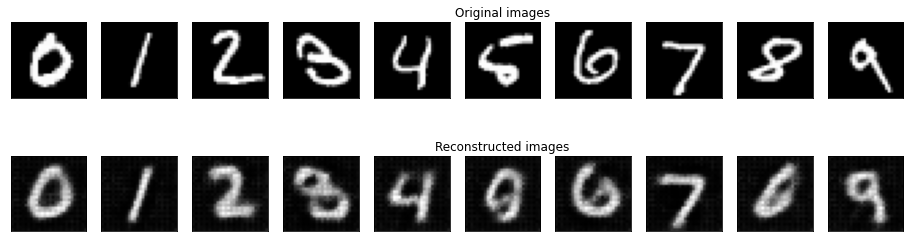

	 partial train loss (single batch): 0.032421
	 partial train loss (single batch): 0.032732
	 partial train loss (single batch): 0.033650
	 partial train loss (single batch): 0.034702
	 partial train loss (single batch): 0.034460
	 partial train loss (single batch): 0.033653
	 partial train loss (single batch): 0.033666
	 partial train loss (single batch): 0.033881
	 partial train loss (single batch): 0.034682
	 partial train loss (single batch): 0.031812
	 partial train loss (single batch): 0.033257
	 partial train loss (single batch): 0.032397
	 partial train loss (single batch): 0.033124
	 partial train loss (single batch): 0.034195
	 partial train loss (single batch): 0.031421
	 partial train loss (single batch): 0.034132
	 partial train loss (single batch): 0.033105
	 partial train loss (single batch): 0.033470
	 partial train loss (single batch): 0.031948
	 partial train loss (single batch): 0.033445
	 partial train loss (single batch): 0.033208
	 partial train loss (single batch

	 partial train loss (single batch): 0.031028
	 partial train loss (single batch): 0.032815
	 partial train loss (single batch): 0.031696
	 partial train loss (single batch): 0.032493
	 partial train loss (single batch): 0.031808
	 partial train loss (single batch): 0.031585
	 partial train loss (single batch): 0.032287

 EPOCH 5/30 	 train loss 0.032433707267045975 	 val loss 0.03184163197875023


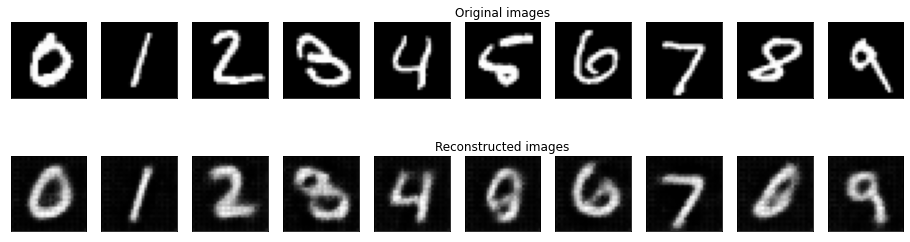

	 partial train loss (single batch): 0.030707
	 partial train loss (single batch): 0.031037
	 partial train loss (single batch): 0.032181
	 partial train loss (single batch): 0.033116
	 partial train loss (single batch): 0.032573
	 partial train loss (single batch): 0.031995
	 partial train loss (single batch): 0.032078
	 partial train loss (single batch): 0.032330
	 partial train loss (single batch): 0.033100
	 partial train loss (single batch): 0.030290
	 partial train loss (single batch): 0.031530
	 partial train loss (single batch): 0.030588
	 partial train loss (single batch): 0.031428
	 partial train loss (single batch): 0.032568
	 partial train loss (single batch): 0.029815
	 partial train loss (single batch): 0.032690
	 partial train loss (single batch): 0.031495
	 partial train loss (single batch): 0.031823
	 partial train loss (single batch): 0.030330
	 partial train loss (single batch): 0.031951
	 partial train loss (single batch): 0.031483
	 partial train loss (single batch

	 partial train loss (single batch): 0.031215
	 partial train loss (single batch): 0.030007
	 partial train loss (single batch): 0.031804
	 partial train loss (single batch): 0.030594
	 partial train loss (single batch): 0.031392
	 partial train loss (single batch): 0.030797
	 partial train loss (single batch): 0.030450
	 partial train loss (single batch): 0.030894

 EPOCH 6/30 	 train loss 0.031114649027585983 	 val loss 0.030930234119296074


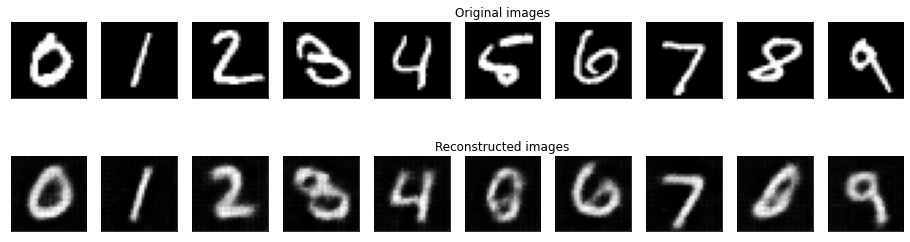

	 partial train loss (single batch): 0.029864
	 partial train loss (single batch): 0.030128
	 partial train loss (single batch): 0.031103
	 partial train loss (single batch): 0.032075
	 partial train loss (single batch): 0.031400
	 partial train loss (single batch): 0.030957
	 partial train loss (single batch): 0.031192
	 partial train loss (single batch): 0.031362
	 partial train loss (single batch): 0.032045
	 partial train loss (single batch): 0.029241
	 partial train loss (single batch): 0.030493
	 partial train loss (single batch): 0.029542
	 partial train loss (single batch): 0.030313
	 partial train loss (single batch): 0.031575
	 partial train loss (single batch): 0.029006
	 partial train loss (single batch): 0.031510
	 partial train loss (single batch): 0.030478
	 partial train loss (single batch): 0.030839
	 partial train loss (single batch): 0.029436
	 partial train loss (single batch): 0.031073
	 partial train loss (single batch): 0.030377
	 partial train loss (single batch

	 partial train loss (single batch): 0.030610
	 partial train loss (single batch): 0.029283
	 partial train loss (single batch): 0.031123
	 partial train loss (single batch): 0.029926
	 partial train loss (single batch): 0.030558
	 partial train loss (single batch): 0.030121
	 partial train loss (single batch): 0.029783
	 partial train loss (single batch): 0.030081

 EPOCH 7/30 	 train loss 0.030277134850621223 	 val loss 0.030331937596201897


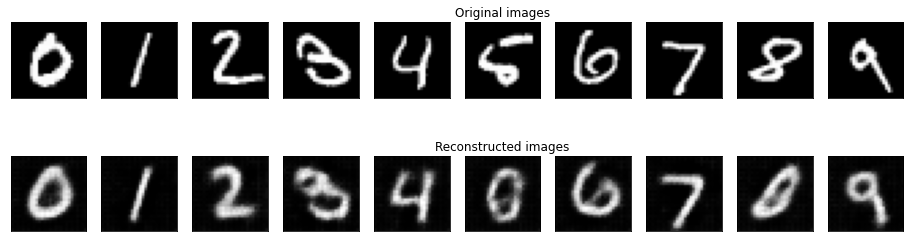

	 partial train loss (single batch): 0.029342
	 partial train loss (single batch): 0.029599
	 partial train loss (single batch): 0.030435
	 partial train loss (single batch): 0.031365
	 partial train loss (single batch): 0.030661
	 partial train loss (single batch): 0.030270
	 partial train loss (single batch): 0.030496
	 partial train loss (single batch): 0.030531
	 partial train loss (single batch): 0.031174
	 partial train loss (single batch): 0.028730
	 partial train loss (single batch): 0.029765
	 partial train loss (single batch): 0.028816
	 partial train loss (single batch): 0.029782
	 partial train loss (single batch): 0.030853
	 partial train loss (single batch): 0.028327
	 partial train loss (single batch): 0.030873
	 partial train loss (single batch): 0.029767
	 partial train loss (single batch): 0.030068
	 partial train loss (single batch): 0.028828
	 partial train loss (single batch): 0.030447
	 partial train loss (single batch): 0.029463
	 partial train loss (single batch

	 partial train loss (single batch): 0.028488
	 partial train loss (single batch): 0.030137
	 partial train loss (single batch): 0.028782
	 partial train loss (single batch): 0.030602
	 partial train loss (single batch): 0.029445
	 partial train loss (single batch): 0.029937
	 partial train loss (single batch): 0.029617
	 partial train loss (single batch): 0.029190
	 partial train loss (single batch): 0.029601

 EPOCH 8/30 	 train loss 0.029666870832443237 	 val loss 0.029943840578198433


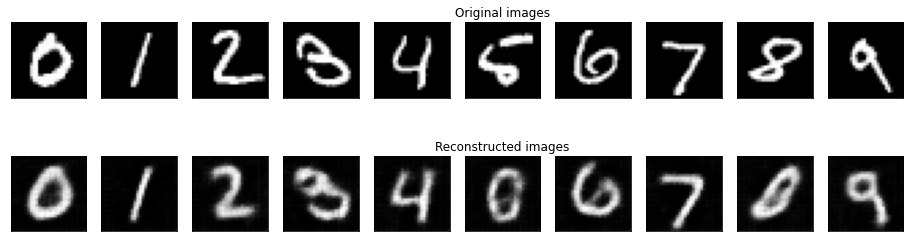

	 partial train loss (single batch): 0.028859
	 partial train loss (single batch): 0.029077
	 partial train loss (single batch): 0.029824
	 partial train loss (single batch): 0.030710
	 partial train loss (single batch): 0.030128
	 partial train loss (single batch): 0.029731
	 partial train loss (single batch): 0.029973
	 partial train loss (single batch): 0.029917
	 partial train loss (single batch): 0.030489
	 partial train loss (single batch): 0.028290
	 partial train loss (single batch): 0.029338
	 partial train loss (single batch): 0.028138
	 partial train loss (single batch): 0.029392
	 partial train loss (single batch): 0.030371
	 partial train loss (single batch): 0.027777
	 partial train loss (single batch): 0.030334
	 partial train loss (single batch): 0.029131
	 partial train loss (single batch): 0.029597
	 partial train loss (single batch): 0.028279
	 partial train loss (single batch): 0.029813
	 partial train loss (single batch): 0.028878
	 partial train loss (single batch

	 partial train loss (single batch): 0.028132
	 partial train loss (single batch): 0.029651
	 partial train loss (single batch): 0.028332
	 partial train loss (single batch): 0.030084
	 partial train loss (single batch): 0.029026
	 partial train loss (single batch): 0.029486
	 partial train loss (single batch): 0.029164
	 partial train loss (single batch): 0.028805
	 partial train loss (single batch): 0.029254

 EPOCH 9/30 	 train loss 0.029174525290727615 	 val loss 0.029470248147845268


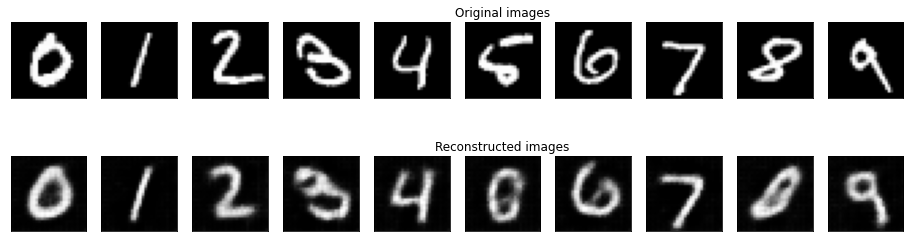

	 partial train loss (single batch): 0.028336
	 partial train loss (single batch): 0.028573
	 partial train loss (single batch): 0.029342
	 partial train loss (single batch): 0.030171
	 partial train loss (single batch): 0.029602
	 partial train loss (single batch): 0.029315
	 partial train loss (single batch): 0.029517
	 partial train loss (single batch): 0.029503
	 partial train loss (single batch): 0.030068
	 partial train loss (single batch): 0.027895
	 partial train loss (single batch): 0.028985
	 partial train loss (single batch): 0.027710
	 partial train loss (single batch): 0.029065
	 partial train loss (single batch): 0.029934
	 partial train loss (single batch): 0.027431
	 partial train loss (single batch): 0.029968
	 partial train loss (single batch): 0.028692
	 partial train loss (single batch): 0.029087
	 partial train loss (single batch): 0.027874
	 partial train loss (single batch): 0.029432
	 partial train loss (single batch): 0.028518
	 partial train loss (single batch

	 partial train loss (single batch): 0.028043
	 partial train loss (single batch): 0.029774
	 partial train loss (single batch): 0.028705
	 partial train loss (single batch): 0.029095
	 partial train loss (single batch): 0.028774
	 partial train loss (single batch): 0.028495
	 partial train loss (single batch): 0.028996

 EPOCH 10/30 	 train loss 0.028783919289708138 	 val loss 0.029085904359817505


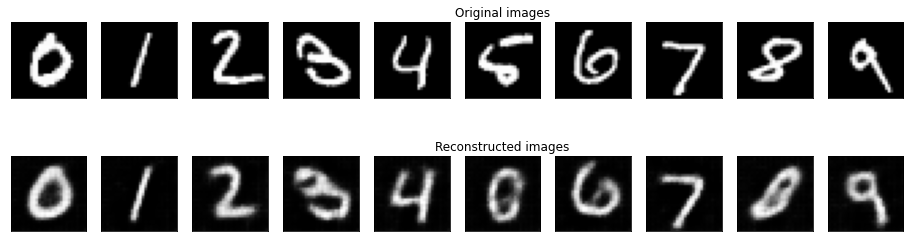

	 partial train loss (single batch): 0.027977
	 partial train loss (single batch): 0.028194
	 partial train loss (single batch): 0.028946
	 partial train loss (single batch): 0.029759
	 partial train loss (single batch): 0.029190
	 partial train loss (single batch): 0.029078
	 partial train loss (single batch): 0.029102
	 partial train loss (single batch): 0.029165
	 partial train loss (single batch): 0.029619
	 partial train loss (single batch): 0.027692
	 partial train loss (single batch): 0.028657
	 partial train loss (single batch): 0.027258
	 partial train loss (single batch): 0.028784
	 partial train loss (single batch): 0.029684
	 partial train loss (single batch): 0.026987
	 partial train loss (single batch): 0.029588
	 partial train loss (single batch): 0.028306
	 partial train loss (single batch): 0.028766
	 partial train loss (single batch): 0.027489
	 partial train loss (single batch): 0.029023
	 partial train loss (single batch): 0.028163
	 partial train loss (single batch

	 partial train loss (single batch): 0.027747
	 partial train loss (single batch): 0.029623
	 partial train loss (single batch): 0.028403
	 partial train loss (single batch): 0.028849
	 partial train loss (single batch): 0.028553
	 partial train loss (single batch): 0.028219
	 partial train loss (single batch): 0.028665

 EPOCH 11/30 	 train loss 0.02846027910709381 	 val loss 0.028837962076067924


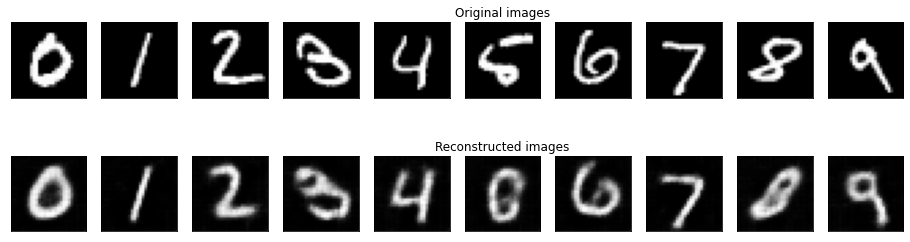

	 partial train loss (single batch): 0.027642
	 partial train loss (single batch): 0.027826
	 partial train loss (single batch): 0.028583
	 partial train loss (single batch): 0.029337
	 partial train loss (single batch): 0.028806
	 partial train loss (single batch): 0.028883
	 partial train loss (single batch): 0.028774
	 partial train loss (single batch): 0.028821
	 partial train loss (single batch): 0.029285
	 partial train loss (single batch): 0.027504
	 partial train loss (single batch): 0.028372
	 partial train loss (single batch): 0.026904
	 partial train loss (single batch): 0.028539
	 partial train loss (single batch): 0.029465
	 partial train loss (single batch): 0.026779
	 partial train loss (single batch): 0.029215
	 partial train loss (single batch): 0.028046
	 partial train loss (single batch): 0.028539
	 partial train loss (single batch): 0.027258
	 partial train loss (single batch): 0.028718
	 partial train loss (single batch): 0.027880
	 partial train loss (single batch

	 partial train loss (single batch): 0.027562
	 partial train loss (single batch): 0.029367
	 partial train loss (single batch): 0.028167
	 partial train loss (single batch): 0.028604
	 partial train loss (single batch): 0.028279
	 partial train loss (single batch): 0.027970
	 partial train loss (single batch): 0.028473

 EPOCH 12/30 	 train loss 0.02816678024828434 	 val loss 0.028581181541085243


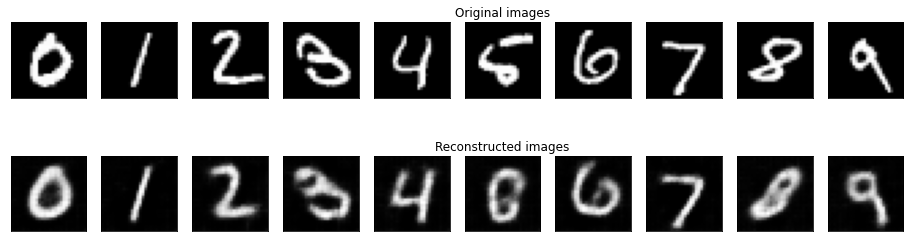

	 partial train loss (single batch): 0.027353
	 partial train loss (single batch): 0.027497
	 partial train loss (single batch): 0.028346
	 partial train loss (single batch): 0.029094
	 partial train loss (single batch): 0.028500
	 partial train loss (single batch): 0.028612
	 partial train loss (single batch): 0.028542
	 partial train loss (single batch): 0.028569
	 partial train loss (single batch): 0.029002
	 partial train loss (single batch): 0.027321
	 partial train loss (single batch): 0.028161
	 partial train loss (single batch): 0.026653
	 partial train loss (single batch): 0.028406
	 partial train loss (single batch): 0.029222
	 partial train loss (single batch): 0.026649
	 partial train loss (single batch): 0.028991
	 partial train loss (single batch): 0.027831
	 partial train loss (single batch): 0.028261
	 partial train loss (single batch): 0.027034
	 partial train loss (single batch): 0.028461
	 partial train loss (single batch): 0.027592
	 partial train loss (single batch

	 partial train loss (single batch): 0.027381
	 partial train loss (single batch): 0.029182
	 partial train loss (single batch): 0.027891
	 partial train loss (single batch): 0.028490
	 partial train loss (single batch): 0.028117
	 partial train loss (single batch): 0.027700
	 partial train loss (single batch): 0.028314

 EPOCH 13/30 	 train loss 0.02793252281844616 	 val loss 0.028436191380023956


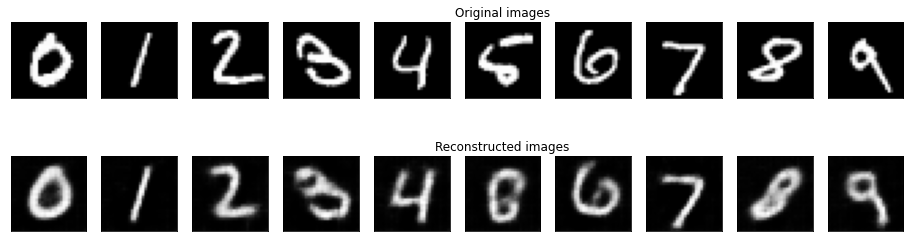

	 partial train loss (single batch): 0.027163
	 partial train loss (single batch): 0.027271
	 partial train loss (single batch): 0.028108
	 partial train loss (single batch): 0.028739
	 partial train loss (single batch): 0.028291
	 partial train loss (single batch): 0.028361
	 partial train loss (single batch): 0.028409
	 partial train loss (single batch): 0.028382
	 partial train loss (single batch): 0.028709
	 partial train loss (single batch): 0.027158
	 partial train loss (single batch): 0.027937
	 partial train loss (single batch): 0.026439
	 partial train loss (single batch): 0.028185
	 partial train loss (single batch): 0.029084
	 partial train loss (single batch): 0.026402
	 partial train loss (single batch): 0.028746
	 partial train loss (single batch): 0.027607
	 partial train loss (single batch): 0.027974
	 partial train loss (single batch): 0.026773
	 partial train loss (single batch): 0.028170
	 partial train loss (single batch): 0.027376
	 partial train loss (single batch

	 partial train loss (single batch): 0.027108
	 partial train loss (single batch): 0.028282
	 partial train loss (single batch): 0.027208
	 partial train loss (single batch): 0.029044
	 partial train loss (single batch): 0.027732
	 partial train loss (single batch): 0.028357
	 partial train loss (single batch): 0.027965
	 partial train loss (single batch): 0.027534
	 partial train loss (single batch): 0.028140

 EPOCH 14/30 	 train loss 0.027727868407964706 	 val loss 0.02818075567483902


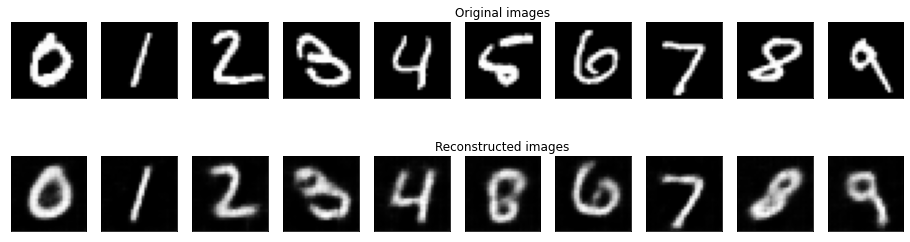

	 partial train loss (single batch): 0.026920
	 partial train loss (single batch): 0.027044
	 partial train loss (single batch): 0.027834
	 partial train loss (single batch): 0.028481
	 partial train loss (single batch): 0.028116
	 partial train loss (single batch): 0.028137
	 partial train loss (single batch): 0.028186
	 partial train loss (single batch): 0.028217
	 partial train loss (single batch): 0.028507
	 partial train loss (single batch): 0.026995
	 partial train loss (single batch): 0.027698
	 partial train loss (single batch): 0.026147
	 partial train loss (single batch): 0.027940
	 partial train loss (single batch): 0.028916
	 partial train loss (single batch): 0.026182
	 partial train loss (single batch): 0.028543
	 partial train loss (single batch): 0.027313
	 partial train loss (single batch): 0.027742
	 partial train loss (single batch): 0.026657
	 partial train loss (single batch): 0.027900
	 partial train loss (single batch): 0.027152
	 partial train loss (single batch

	 partial train loss (single batch): 0.028107
	 partial train loss (single batch): 0.027009
	 partial train loss (single batch): 0.028831
	 partial train loss (single batch): 0.027485
	 partial train loss (single batch): 0.028172
	 partial train loss (single batch): 0.027804
	 partial train loss (single batch): 0.027456
	 partial train loss (single batch): 0.028133

 EPOCH 15/30 	 train loss 0.027538131922483444 	 val loss 0.02797398343682289


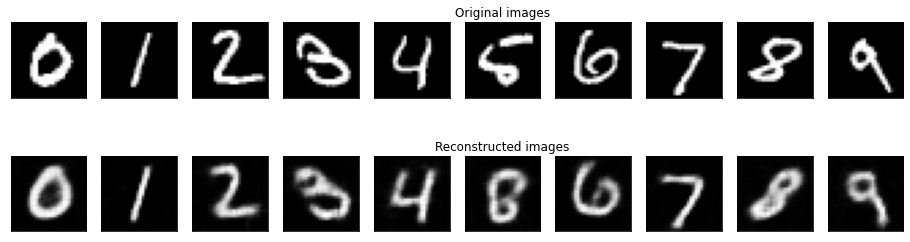

	 partial train loss (single batch): 0.026781
	 partial train loss (single batch): 0.026934
	 partial train loss (single batch): 0.027632
	 partial train loss (single batch): 0.028250
	 partial train loss (single batch): 0.027904
	 partial train loss (single batch): 0.027976
	 partial train loss (single batch): 0.028017
	 partial train loss (single batch): 0.028049
	 partial train loss (single batch): 0.028344
	 partial train loss (single batch): 0.026814
	 partial train loss (single batch): 0.027584
	 partial train loss (single batch): 0.025942
	 partial train loss (single batch): 0.027787
	 partial train loss (single batch): 0.028732
	 partial train loss (single batch): 0.025972
	 partial train loss (single batch): 0.028365
	 partial train loss (single batch): 0.027152
	 partial train loss (single batch): 0.027507
	 partial train loss (single batch): 0.026473
	 partial train loss (single batch): 0.027635
	 partial train loss (single batch): 0.026974
	 partial train loss (single batch

	 partial train loss (single batch): 0.027987
	 partial train loss (single batch): 0.026895
	 partial train loss (single batch): 0.028671
	 partial train loss (single batch): 0.027311
	 partial train loss (single batch): 0.027959
	 partial train loss (single batch): 0.027671
	 partial train loss (single batch): 0.027277
	 partial train loss (single batch): 0.028030

 EPOCH 16/30 	 train loss 0.027364959940314293 	 val loss 0.0278820488601923


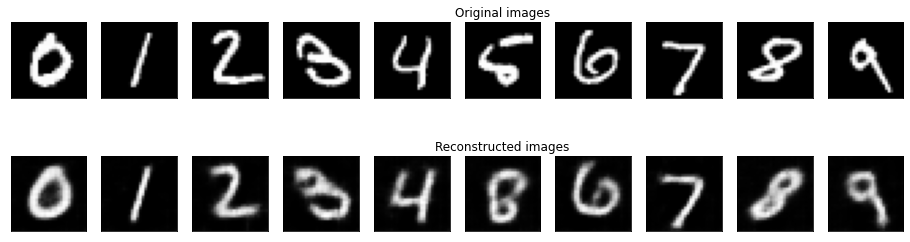

	 partial train loss (single batch): 0.026650
	 partial train loss (single batch): 0.026768
	 partial train loss (single batch): 0.027496
	 partial train loss (single batch): 0.028104
	 partial train loss (single batch): 0.027741
	 partial train loss (single batch): 0.027865
	 partial train loss (single batch): 0.027901
	 partial train loss (single batch): 0.027881
	 partial train loss (single batch): 0.028160
	 partial train loss (single batch): 0.026678
	 partial train loss (single batch): 0.027363
	 partial train loss (single batch): 0.025738
	 partial train loss (single batch): 0.027559
	 partial train loss (single batch): 0.028577
	 partial train loss (single batch): 0.025818
	 partial train loss (single batch): 0.028174
	 partial train loss (single batch): 0.027006
	 partial train loss (single batch): 0.027353
	 partial train loss (single batch): 0.026321
	 partial train loss (single batch): 0.027459
	 partial train loss (single batch): 0.026837
	 partial train loss (single batch

	 partial train loss (single batch): 0.026743
	 partial train loss (single batch): 0.028593
	 partial train loss (single batch): 0.027134
	 partial train loss (single batch): 0.027777
	 partial train loss (single batch): 0.027558
	 partial train loss (single batch): 0.027140
	 partial train loss (single batch): 0.027920

 EPOCH 17/30 	 train loss 0.02722301334142685 	 val loss 0.027779288589954376


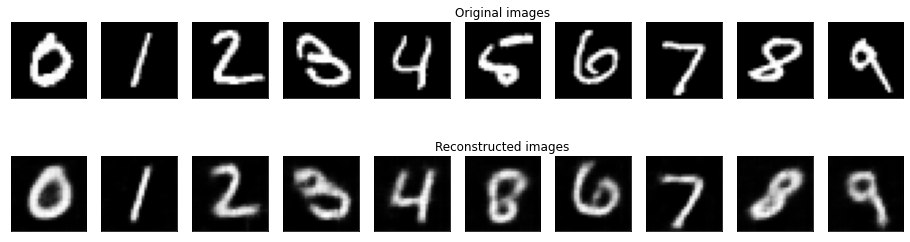

	 partial train loss (single batch): 0.026568
	 partial train loss (single batch): 0.026653
	 partial train loss (single batch): 0.027273
	 partial train loss (single batch): 0.027938
	 partial train loss (single batch): 0.027523
	 partial train loss (single batch): 0.027688
	 partial train loss (single batch): 0.027692
	 partial train loss (single batch): 0.027656
	 partial train loss (single batch): 0.027998
	 partial train loss (single batch): 0.026427
	 partial train loss (single batch): 0.027130
	 partial train loss (single batch): 0.025597
	 partial train loss (single batch): 0.027386
	 partial train loss (single batch): 0.028392
	 partial train loss (single batch): 0.025677
	 partial train loss (single batch): 0.027996
	 partial train loss (single batch): 0.026777
	 partial train loss (single batch): 0.027187
	 partial train loss (single batch): 0.026163
	 partial train loss (single batch): 0.027331
	 partial train loss (single batch): 0.026685
	 partial train loss (single batch

	 partial train loss (single batch): 0.026602
	 partial train loss (single batch): 0.028529
	 partial train loss (single batch): 0.026934
	 partial train loss (single batch): 0.027674
	 partial train loss (single batch): 0.027524
	 partial train loss (single batch): 0.027039
	 partial train loss (single batch): 0.027886

 EPOCH 18/30 	 train loss 0.027081504464149475 	 val loss 0.027696652337908745


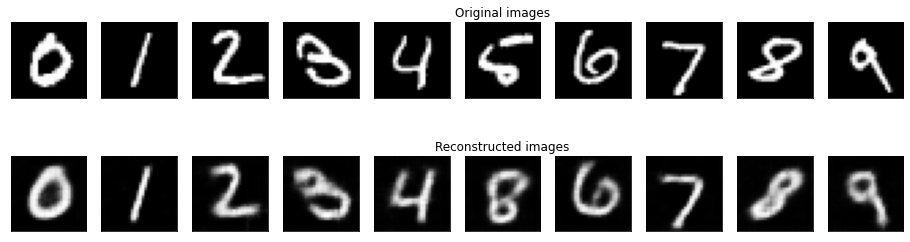

	 partial train loss (single batch): 0.026477
	 partial train loss (single batch): 0.026497
	 partial train loss (single batch): 0.027113
	 partial train loss (single batch): 0.027817
	 partial train loss (single batch): 0.027394
	 partial train loss (single batch): 0.027567
	 partial train loss (single batch): 0.027563
	 partial train loss (single batch): 0.027522
	 partial train loss (single batch): 0.027811
	 partial train loss (single batch): 0.026333
	 partial train loss (single batch): 0.026999
	 partial train loss (single batch): 0.025463
	 partial train loss (single batch): 0.027356
	 partial train loss (single batch): 0.028308
	 partial train loss (single batch): 0.025646
	 partial train loss (single batch): 0.027920
	 partial train loss (single batch): 0.026657
	 partial train loss (single batch): 0.027063
	 partial train loss (single batch): 0.026017
	 partial train loss (single batch): 0.027197
	 partial train loss (single batch): 0.026604
	 partial train loss (single batch

	 partial train loss (single batch): 0.027545
	 partial train loss (single batch): 0.026443
	 partial train loss (single batch): 0.028378
	 partial train loss (single batch): 0.026872
	 partial train loss (single batch): 0.027495
	 partial train loss (single batch): 0.027373
	 partial train loss (single batch): 0.026905
	 partial train loss (single batch): 0.027701

 EPOCH 19/30 	 train loss 0.026955416426062584 	 val loss 0.02752557396888733


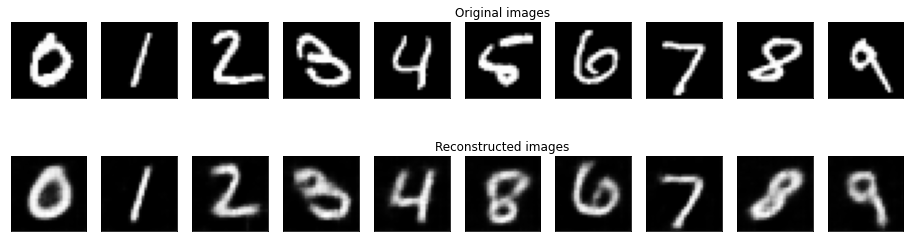

	 partial train loss (single batch): 0.026319
	 partial train loss (single batch): 0.026364
	 partial train loss (single batch): 0.026881
	 partial train loss (single batch): 0.027743
	 partial train loss (single batch): 0.027333
	 partial train loss (single batch): 0.027374
	 partial train loss (single batch): 0.027423
	 partial train loss (single batch): 0.027324
	 partial train loss (single batch): 0.027702
	 partial train loss (single batch): 0.026246
	 partial train loss (single batch): 0.026841
	 partial train loss (single batch): 0.025342
	 partial train loss (single batch): 0.027127
	 partial train loss (single batch): 0.028219
	 partial train loss (single batch): 0.025598
	 partial train loss (single batch): 0.027804
	 partial train loss (single batch): 0.026504
	 partial train loss (single batch): 0.026947
	 partial train loss (single batch): 0.025952
	 partial train loss (single batch): 0.027171
	 partial train loss (single batch): 0.026537
	 partial train loss (single batch

	 partial train loss (single batch): 0.026240
	 partial train loss (single batch): 0.028179
	 partial train loss (single batch): 0.026658
	 partial train loss (single batch): 0.027320
	 partial train loss (single batch): 0.027197
	 partial train loss (single batch): 0.026816
	 partial train loss (single batch): 0.027461

 EPOCH 20/30 	 train loss 0.026836248114705086 	 val loss 0.027420496568083763


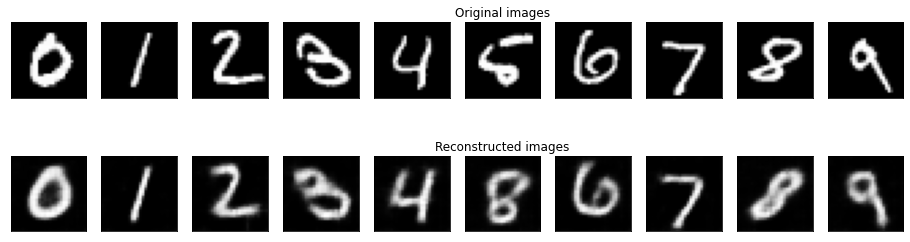

	 partial train loss (single batch): 0.026156
	 partial train loss (single batch): 0.026190
	 partial train loss (single batch): 0.026756
	 partial train loss (single batch): 0.027603
	 partial train loss (single batch): 0.027191
	 partial train loss (single batch): 0.027266
	 partial train loss (single batch): 0.027274
	 partial train loss (single batch): 0.027153
	 partial train loss (single batch): 0.027537
	 partial train loss (single batch): 0.026167
	 partial train loss (single batch): 0.026725
	 partial train loss (single batch): 0.025202
	 partial train loss (single batch): 0.026982
	 partial train loss (single batch): 0.028091
	 partial train loss (single batch): 0.025480
	 partial train loss (single batch): 0.027692
	 partial train loss (single batch): 0.026388
	 partial train loss (single batch): 0.026818
	 partial train loss (single batch): 0.025798
	 partial train loss (single batch): 0.027050
	 partial train loss (single batch): 0.026369
	 partial train loss (single batch

	 partial train loss (single batch): 0.027252
	 partial train loss (single batch): 0.026142
	 partial train loss (single batch): 0.028055
	 partial train loss (single batch): 0.026493
	 partial train loss (single batch): 0.027232
	 partial train loss (single batch): 0.027083
	 partial train loss (single batch): 0.026641
	 partial train loss (single batch): 0.027298

 EPOCH 21/30 	 train loss 0.02671971172094345 	 val loss 0.02732170559465885


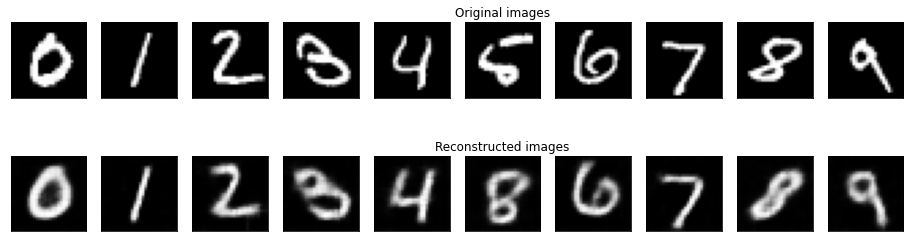

	 partial train loss (single batch): 0.025997
	 partial train loss (single batch): 0.026016
	 partial train loss (single batch): 0.026551
	 partial train loss (single batch): 0.027516
	 partial train loss (single batch): 0.027162
	 partial train loss (single batch): 0.027142
	 partial train loss (single batch): 0.027208
	 partial train loss (single batch): 0.026978
	 partial train loss (single batch): 0.027454
	 partial train loss (single batch): 0.026101
	 partial train loss (single batch): 0.026677
	 partial train loss (single batch): 0.025105
	 partial train loss (single batch): 0.026872
	 partial train loss (single batch): 0.028086
	 partial train loss (single batch): 0.025394
	 partial train loss (single batch): 0.027631
	 partial train loss (single batch): 0.026362
	 partial train loss (single batch): 0.026818
	 partial train loss (single batch): 0.025733
	 partial train loss (single batch): 0.026983
	 partial train loss (single batch): 0.026290
	 partial train loss (single batch

	 partial train loss (single batch): 0.026089
	 partial train loss (single batch): 0.028025
	 partial train loss (single batch): 0.026442
	 partial train loss (single batch): 0.027148
	 partial train loss (single batch): 0.026987
	 partial train loss (single batch): 0.026607
	 partial train loss (single batch): 0.027062

 EPOCH 22/30 	 train loss 0.02662723697721958 	 val loss 0.0272890105843544


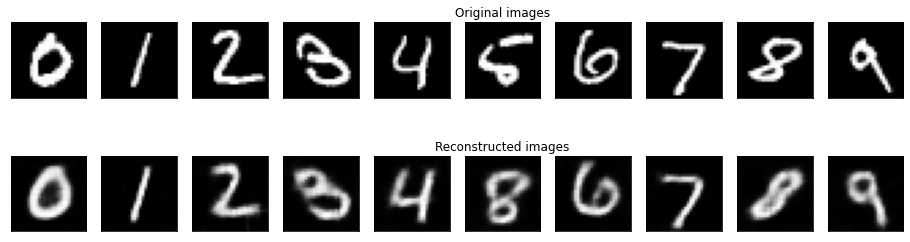

	 partial train loss (single batch): 0.025873
	 partial train loss (single batch): 0.025953
	 partial train loss (single batch): 0.026441
	 partial train loss (single batch): 0.027341
	 partial train loss (single batch): 0.027048
	 partial train loss (single batch): 0.026962
	 partial train loss (single batch): 0.027198
	 partial train loss (single batch): 0.026828
	 partial train loss (single batch): 0.027288
	 partial train loss (single batch): 0.026107
	 partial train loss (single batch): 0.026618
	 partial train loss (single batch): 0.024995
	 partial train loss (single batch): 0.026821
	 partial train loss (single batch): 0.028007
	 partial train loss (single batch): 0.025418
	 partial train loss (single batch): 0.027482
	 partial train loss (single batch): 0.026336
	 partial train loss (single batch): 0.026823
	 partial train loss (single batch): 0.025611
	 partial train loss (single batch): 0.026976
	 partial train loss (single batch): 0.026331
	 partial train loss (single batch

	 partial train loss (single batch): 0.026022
	 partial train loss (single batch): 0.027913
	 partial train loss (single batch): 0.026288
	 partial train loss (single batch): 0.027096
	 partial train loss (single batch): 0.026991
	 partial train loss (single batch): 0.026482
	 partial train loss (single batch): 0.026939

 EPOCH 23/30 	 train loss 0.02654377371072769 	 val loss 0.02717485837638378


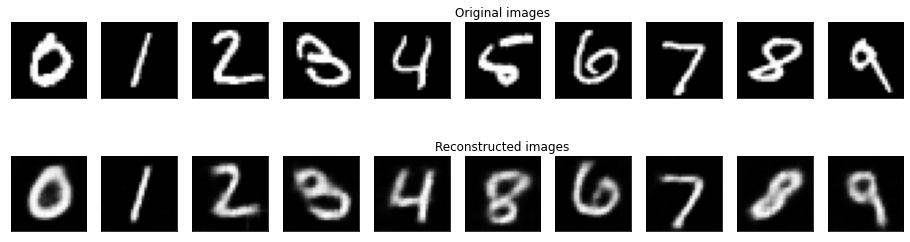

	 partial train loss (single batch): 0.025735
	 partial train loss (single batch): 0.025837
	 partial train loss (single batch): 0.026309
	 partial train loss (single batch): 0.027291
	 partial train loss (single batch): 0.027041
	 partial train loss (single batch): 0.026824
	 partial train loss (single batch): 0.027140
	 partial train loss (single batch): 0.026755
	 partial train loss (single batch): 0.027266
	 partial train loss (single batch): 0.025926
	 partial train loss (single batch): 0.026574
	 partial train loss (single batch): 0.024926
	 partial train loss (single batch): 0.026711
	 partial train loss (single batch): 0.027966
	 partial train loss (single batch): 0.025413
	 partial train loss (single batch): 0.027364
	 partial train loss (single batch): 0.026214
	 partial train loss (single batch): 0.026767
	 partial train loss (single batch): 0.025592
	 partial train loss (single batch): 0.026873
	 partial train loss (single batch): 0.026205
	 partial train loss (single batch

	 partial train loss (single batch): 0.025895
	 partial train loss (single batch): 0.027809
	 partial train loss (single batch): 0.026093
	 partial train loss (single batch): 0.027125
	 partial train loss (single batch): 0.026929
	 partial train loss (single batch): 0.026317
	 partial train loss (single batch): 0.026741

 EPOCH 24/30 	 train loss 0.026451660320162773 	 val loss 0.027092553675174713


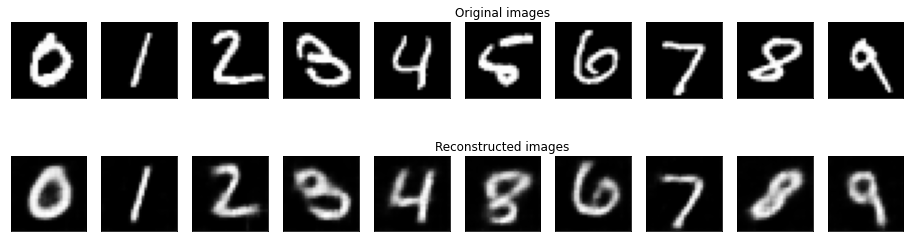

	 partial train loss (single batch): 0.025689
	 partial train loss (single batch): 0.025780
	 partial train loss (single batch): 0.026202
	 partial train loss (single batch): 0.027195
	 partial train loss (single batch): 0.026918
	 partial train loss (single batch): 0.026700
	 partial train loss (single batch): 0.027020
	 partial train loss (single batch): 0.026704
	 partial train loss (single batch): 0.027244
	 partial train loss (single batch): 0.025834
	 partial train loss (single batch): 0.026473
	 partial train loss (single batch): 0.024901
	 partial train loss (single batch): 0.026667
	 partial train loss (single batch): 0.027906
	 partial train loss (single batch): 0.025289
	 partial train loss (single batch): 0.027324
	 partial train loss (single batch): 0.026138
	 partial train loss (single batch): 0.026693
	 partial train loss (single batch): 0.025391
	 partial train loss (single batch): 0.026711
	 partial train loss (single batch): 0.026083
	 partial train loss (single batch

	 partial train loss (single batch): 0.026826
	 partial train loss (single batch): 0.025757
	 partial train loss (single batch): 0.027766
	 partial train loss (single batch): 0.025978
	 partial train loss (single batch): 0.026919
	 partial train loss (single batch): 0.026820
	 partial train loss (single batch): 0.026293
	 partial train loss (single batch): 0.026673

 EPOCH 25/30 	 train loss 0.026361698284745216 	 val loss 0.026986371725797653


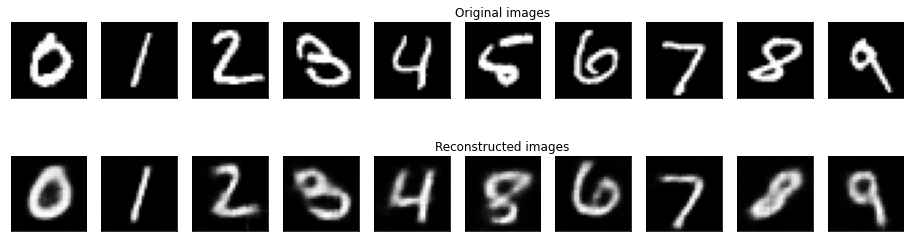

	 partial train loss (single batch): 0.025613
	 partial train loss (single batch): 0.025685
	 partial train loss (single batch): 0.026177
	 partial train loss (single batch): 0.027084
	 partial train loss (single batch): 0.026862
	 partial train loss (single batch): 0.026538
	 partial train loss (single batch): 0.026968
	 partial train loss (single batch): 0.026581
	 partial train loss (single batch): 0.027092
	 partial train loss (single batch): 0.025709
	 partial train loss (single batch): 0.026439
	 partial train loss (single batch): 0.024818
	 partial train loss (single batch): 0.026442
	 partial train loss (single batch): 0.027793
	 partial train loss (single batch): 0.025320
	 partial train loss (single batch): 0.027248
	 partial train loss (single batch): 0.025921
	 partial train loss (single batch): 0.026595
	 partial train loss (single batch): 0.025402
	 partial train loss (single batch): 0.026644
	 partial train loss (single batch): 0.025993
	 partial train loss (single batch

	 partial train loss (single batch): 0.026774
	 partial train loss (single batch): 0.025718
	 partial train loss (single batch): 0.027617
	 partial train loss (single batch): 0.025865
	 partial train loss (single batch): 0.026781
	 partial train loss (single batch): 0.026786
	 partial train loss (single batch): 0.026200
	 partial train loss (single batch): 0.026541

 EPOCH 26/30 	 train loss 0.026277760043740273 	 val loss 0.026925235986709595


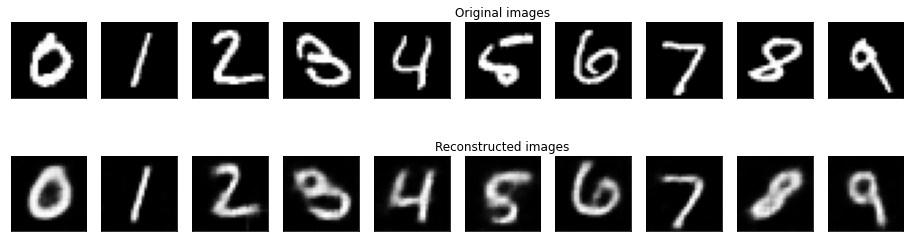

	 partial train loss (single batch): 0.025549
	 partial train loss (single batch): 0.025597
	 partial train loss (single batch): 0.026068
	 partial train loss (single batch): 0.027074
	 partial train loss (single batch): 0.026806
	 partial train loss (single batch): 0.026523
	 partial train loss (single batch): 0.026898
	 partial train loss (single batch): 0.026465
	 partial train loss (single batch): 0.027042
	 partial train loss (single batch): 0.025627
	 partial train loss (single batch): 0.026289
	 partial train loss (single batch): 0.024788
	 partial train loss (single batch): 0.026287
	 partial train loss (single batch): 0.027706
	 partial train loss (single batch): 0.025256
	 partial train loss (single batch): 0.027217
	 partial train loss (single batch): 0.025827
	 partial train loss (single batch): 0.026476
	 partial train loss (single batch): 0.025300
	 partial train loss (single batch): 0.026555
	 partial train loss (single batch): 0.025870
	 partial train loss (single batch

	 partial train loss (single batch): 0.025609
	 partial train loss (single batch): 0.027471
	 partial train loss (single batch): 0.025775
	 partial train loss (single batch): 0.026639
	 partial train loss (single batch): 0.026729
	 partial train loss (single batch): 0.026155
	 partial train loss (single batch): 0.026525

 EPOCH 27/30 	 train loss 0.026196584105491638 	 val loss 0.0268548596650362


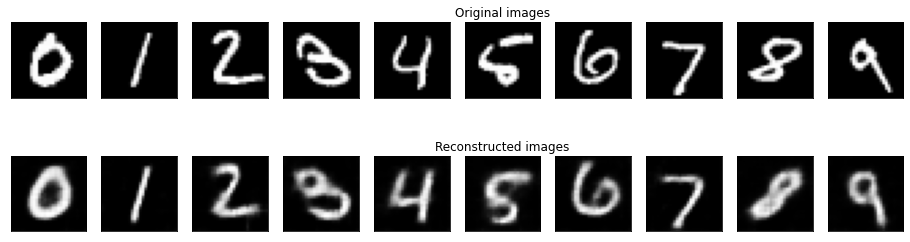

	 partial train loss (single batch): 0.025442
	 partial train loss (single batch): 0.025534
	 partial train loss (single batch): 0.025902
	 partial train loss (single batch): 0.026838
	 partial train loss (single batch): 0.026727
	 partial train loss (single batch): 0.026394
	 partial train loss (single batch): 0.026852
	 partial train loss (single batch): 0.026270
	 partial train loss (single batch): 0.026963
	 partial train loss (single batch): 0.025524
	 partial train loss (single batch): 0.026153
	 partial train loss (single batch): 0.024719
	 partial train loss (single batch): 0.026175
	 partial train loss (single batch): 0.027523
	 partial train loss (single batch): 0.025193
	 partial train loss (single batch): 0.027095
	 partial train loss (single batch): 0.025721
	 partial train loss (single batch): 0.026523
	 partial train loss (single batch): 0.025241
	 partial train loss (single batch): 0.026403
	 partial train loss (single batch): 0.025835
	 partial train loss (single batch

	 partial train loss (single batch): 0.025515
	 partial train loss (single batch): 0.027371
	 partial train loss (single batch): 0.025718
	 partial train loss (single batch): 0.026545
	 partial train loss (single batch): 0.026625
	 partial train loss (single batch): 0.026108
	 partial train loss (single batch): 0.026428

 EPOCH 28/30 	 train loss 0.02611749805510044 	 val loss 0.02675466425716877


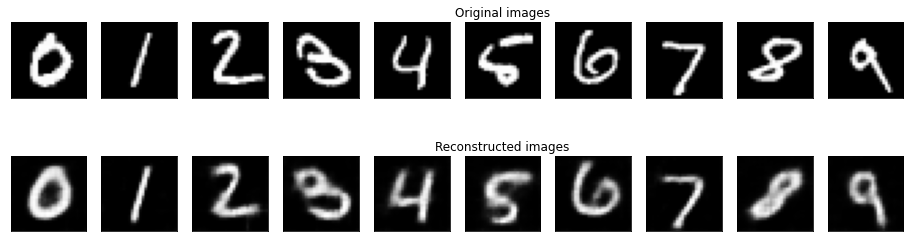

	 partial train loss (single batch): 0.025321
	 partial train loss (single batch): 0.025480
	 partial train loss (single batch): 0.025843
	 partial train loss (single batch): 0.026727
	 partial train loss (single batch): 0.026641
	 partial train loss (single batch): 0.026296
	 partial train loss (single batch): 0.026806
	 partial train loss (single batch): 0.026256
	 partial train loss (single batch): 0.026905
	 partial train loss (single batch): 0.025433
	 partial train loss (single batch): 0.026051
	 partial train loss (single batch): 0.024663
	 partial train loss (single batch): 0.026038
	 partial train loss (single batch): 0.027486
	 partial train loss (single batch): 0.024984
	 partial train loss (single batch): 0.027010
	 partial train loss (single batch): 0.025581
	 partial train loss (single batch): 0.026325
	 partial train loss (single batch): 0.025107
	 partial train loss (single batch): 0.026338
	 partial train loss (single batch): 0.025680
	 partial train loss (single batch

	 partial train loss (single batch): 0.025964
	 partial train loss (single batch): 0.026469
	 partial train loss (single batch): 0.025441
	 partial train loss (single batch): 0.027385
	 partial train loss (single batch): 0.025609
	 partial train loss (single batch): 0.026460
	 partial train loss (single batch): 0.026498
	 partial train loss (single batch): 0.026033
	 partial train loss (single batch): 0.026283

 EPOCH 29/30 	 train loss 0.026045167818665504 	 val loss 0.026680994778871536


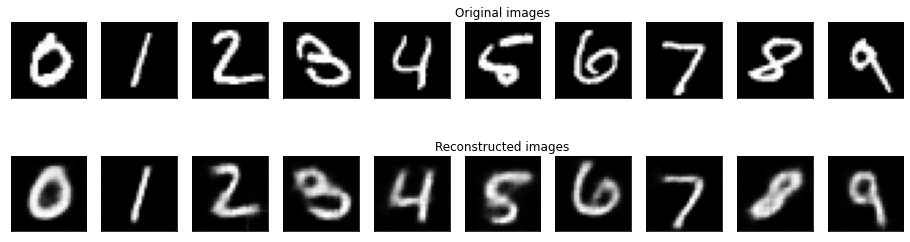

	 partial train loss (single batch): 0.025200
	 partial train loss (single batch): 0.025314
	 partial train loss (single batch): 0.025771
	 partial train loss (single batch): 0.026573
	 partial train loss (single batch): 0.026531
	 partial train loss (single batch): 0.026236
	 partial train loss (single batch): 0.026708
	 partial train loss (single batch): 0.026169
	 partial train loss (single batch): 0.026864
	 partial train loss (single batch): 0.025338
	 partial train loss (single batch): 0.025997
	 partial train loss (single batch): 0.024608
	 partial train loss (single batch): 0.025917
	 partial train loss (single batch): 0.027389
	 partial train loss (single batch): 0.024895
	 partial train loss (single batch): 0.026997
	 partial train loss (single batch): 0.025548
	 partial train loss (single batch): 0.026168
	 partial train loss (single batch): 0.025072
	 partial train loss (single batch): 0.026335
	 partial train loss (single batch): 0.025629
	 partial train loss (single batch

	 partial train loss (single batch): 0.026412
	 partial train loss (single batch): 0.025400
	 partial train loss (single batch): 0.027398
	 partial train loss (single batch): 0.025537
	 partial train loss (single batch): 0.026389
	 partial train loss (single batch): 0.026385
	 partial train loss (single batch): 0.025999
	 partial train loss (single batch): 0.026275

 EPOCH 30/30 	 train loss 0.025964168831706047 	 val loss 0.026726115494966507


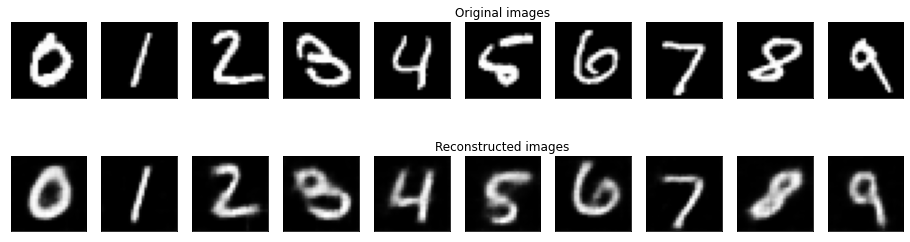

In [7]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

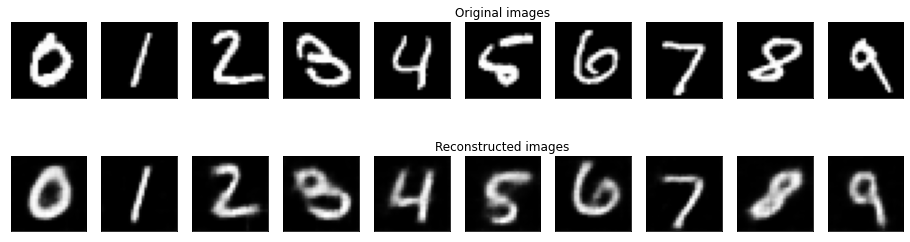

In [8]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()
plot_ae_outputs(encoder, decoder, n=10)

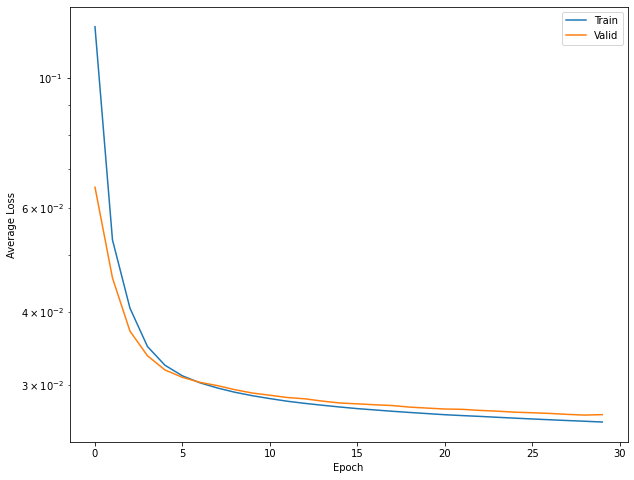

In [9]:

# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

tensor([-0.1681,  0.1746,  0.1182,  0.0787])
tensor([0.8120, 0.6711, 0.6419, 0.5732])


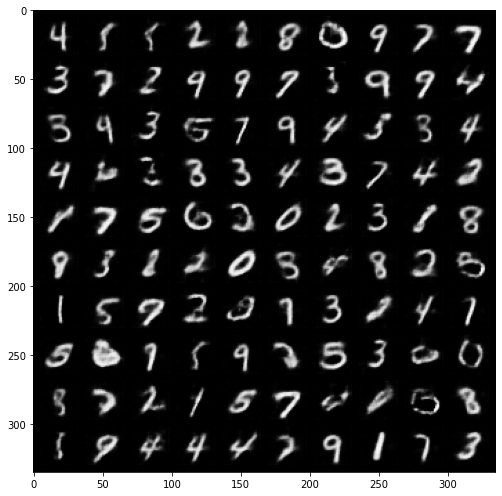

In [10]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = iter(test_loader).next()
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

In [11]:
from tqdm import tqdm

encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:03<00:00, 2838.73it/s]


Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0           -2.233399         1.514614         1.536440         0.385413   
1            1.061611        -0.070671         1.846913         1.187899   
2           -0.189528         0.872174         0.488089         1.481387   
3            0.052778        -0.558492         0.050241        -0.569328   
4           -1.325168         0.497171        -0.540605        -0.580946   
...               ...              ...              ...              ...   
9995         0.626784        -0.488350         0.892887         0.301529   
9996         0.884658         0.219025         0.104663        -0.190953   
9997        -1.351991         0.301670        -0.294348         0.297535   
9998        -0.218084        -0.703560        -1.185945         0.432020   
9999        -0.129479        -0.800891         0.456831        -0.500352   

      label  
0         7  
1         2  
2         1  
3         0  
4         4  
...     ...  
9995      2  
9996      3  
9997      4  
9998      5  
9999      6  

[10000 rows x 5 columns]

In [12]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()